In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [67]:
class Tree(object):
    def __init__(self, depth=0, w=None, f_index=0, *args, **kwargs):
        self.w = w
        self.left = None
        self.right = None
        self.cat_val = None
        self.f_index = f_index
        self.depth = depth

    def set_children(self, l, r):
        self.left = l
        self.right = r

    def set_w(self, w):
        self.w = w

    def set_cat_val(self, val):
        self.cat_val = val


In [229]:
class DecisionTreeRegression(torch.nn.Module):
    """Second try to create normal DTR"""
    def __init__(self, n_features, cat_indexes=None, 
        max_depth=3, ig_func='mae', *args, **kwargs):
        super(DecisionTreeRegression, self).__init__(*args, **kwargs)
        self.types = [0]*n_features
        self.max_depth = max_depth
        self.tree = None

        if ig_func == 'mae':
            self.func = DecisionTreeRegression.mae
            self.ig_func = DecisionTreeRegression.ig_mae
        elif ig_func == 'mse':
            self.func = DecisionTreeRegression.mse
            self.ig_func = DecisionTreeRegression.ig_mse
        else:
            raise "Not a ig function"

        if cat_indexes is not None:
            for i in cat_indexes:
                self.types[i] = 1
        
    def train(self, X, Y):
        self.tree = Tree()
        rec_list = [(self.tree, X, Y)]
        # print("shape", Y.shape)
        while len(rec_list) and rec_list[0][0].depth <= self.max_depth:
            node = rec_list.pop(0)
            # print("new train", node[0].depth)
            f_ind, f_val = self.best_split(node[1], node[2])
            s = self.split(node[1], node[2], f_ind, f_val)
            nl = Tree(node[0].depth + 1)
            nr = Tree(node[0].depth + 1)
            node[0].set_cat_val(self.mean(node[2]))
            node[0].set_w(f_val)
            node[0].set_children(nl, nr)

            if len(s[2]):
                rec_list.append((nl, s[0], s[2]))
                # print('adl', len(s[2]))
            if len(s[3]):
                rec_list.append((nr, s[1], s[3]))
                # print('adr', len(s[3]))

        return self.tree

    def predict(self, X):
        yp = np.empty(X.shape[0])
        for i, xi in enumerate(X):
            yp[i] = self.forward(xi)
        return yp

    def forward(self, x):
        res = None
        node = self.tree
        if node.w is None:
            return None

        while res is None:
            ki = x == node.w if self.types[node.f_index] else x <= node.w
            if ki:
                if node.left is None or node.left.cat_val is None:
                    res = node.cat_val
                else:
                    node = node.left
            else:
                if node.right is None or node.right.cat_val is None:
                    res = node.cat_val
                else:
                    node = node.right
        return res

    @staticmethod
    def mae(Y):
        u = DecisionTreeRegression.median(Y)
        return sum(np.abs(Y - u))/len(Y)

    @staticmethod
    def mse(Y):
        u = DecisionTreeRegression.mean(Y)
        return sum( (Y-u)**2 )/len(Y)

    @staticmethod
    def ig_mae(Y_prev, Y_new):
        err = sum([DecisionTreeRegression.mae(y) * len(y)/len(Y_prev) for y in Y_new])
        return DecisionTreeRegression.mae(Y_prev) - err
    
    @staticmethod
    def ig_mse(Y_prev, Y_new):
        err = sum([DecisionTreeRegression.mse(y) * len(y)/len(Y_prev) for y in Y_new])
        return DecisionTreeRegression.mse(Y_prev) - err
    
    @staticmethod
    def mean(Y):
        return sum(Y)/len(Y)

    @staticmethod
    def median(Y):
        w = sorted(Y)
        return w[len(w)//2]
    
    def split(self, X, Y, f_index, f_val):
        ki = X[:,f_index] == f_val if self.types[f_index] else X[:,f_index] <= f_val
        xl, xr = X[ki], X[~ki]
        yl, yr = Y[ki], Y[~ki]
        return xl, xr, yl, yr

    def split_features(self, X, Y, f_index):
        vals = np.unique(X[:,f_index])
        b_ig = 0
        b_index = 0
        b_val = vals[0]
        for i, val in enumerate(vals):
            S = self.split(X, Y, f_index, val)
            if not len(S[3]) or not len(S[2]):
                continue
            ig = self.ig_func(Y, S[2:])
            # print(f"ig: {ig}")
            if ig > b_ig:
                b_ig = ig
                b_index = i
                b_val = val
        return b_val, b_ig

    def best_split(self, X, Y):
        b_find = 0
        b_val = 0
        b_ig = 0
        for i in range(X.shape[1]):
            val, ig = self.split_features(X, Y, i)
            # print(f"bs; Xshape: {X.shape} b_ig: {ig}")
            if ig > b_ig:
                b_ig = ig
                b_val = val
                b_find = i
        return b_find, b_val


In [230]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

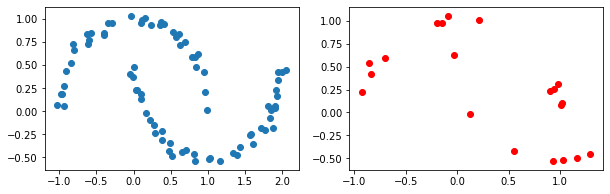

In [231]:
X, Y = make_moons(noise=0.05, n_samples=100, random_state=20)
x = X[:,0]
y = X[:,1]
xtr, xte, ytr, yte = train_test_split(x,y, test_size=.2, random_state=10)
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].scatter(xtr, ytr)
axes[1].scatter(xte, yte, color='r')
# axes[2].scatter(X[:0],X[:,1], color=)

In [264]:
DCT = DecisionTreeRegression(1, max_depth=20, ig_func='mae')
xtr1 = xtr.reshape(-1,1)
xte1 = xte.reshape(-1,1)
DCT.train(xtr1, ytr)

In [265]:
yp1 = DCT.predict(xtr1)
yp2 = DCT.predict(xte1)

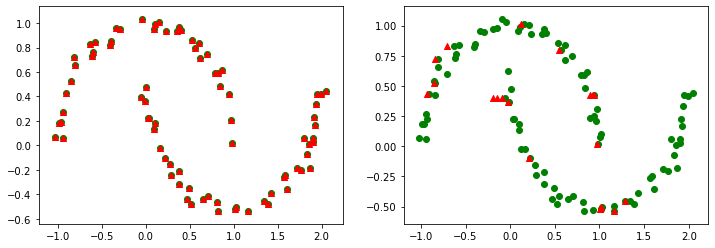

In [266]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr1, ytr, color='g')
axes[0].scatter(xtr1, yp1, color='r', marker='^')

axes[1].scatter(xtr1, ytr, color='g')
axes[1].scatter(xte1, yte, color='g')
axes[1].scatter(xte1, yp2, color='r', marker='^')
fig.savefig("norm_DTR.png", dpi=150)

In [267]:
from sklearn.tree import DecisionTreeRegressor

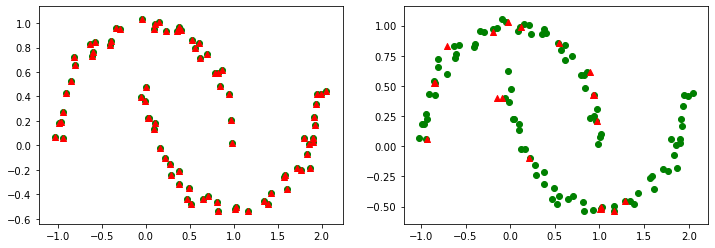

In [268]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

reg = DecisionTreeRegressor(random_state=0, max_depth=20, splitter='best', criterion='mae')
xtr2, xte2 = xtr.reshape(-1,1), xte.reshape(-1,1)
# ytr2, yte2 = ytr.reshape(-1,1), xte2.reshape(-1,1)

reg.fit(xtr2,ytr)
yp1 = reg.predict(xtr2)
yp2 = reg.predict(xte2)
axes[0].scatter(xtr2, ytr, color='g')
axes[0].scatter(xtr2, yp1, color='r', marker='^')

axes[1].scatter(xtr2, ytr, color='g')
axes[1].scatter(xte2, yte, color='g')
axes[1].scatter(xte2, yp2, color='r', marker='^')


In [315]:
xp = pd.DataFrame(X)
xp.sort_values(0, axis=0, inplace=True)
xpn = np.array(xp)
x = xpn[:,0]
y = xpn[:,1]
xtr2, xte2, ytr2, yte2 = train_test_split(x,y, test_size=.2, random_state=10)
xp = pd.DataFrame((xtr2, ytr2)).T
xp.sort_values(0, inplace=True)
xt = np.array(xp)
print(xt.shape)
xp = pd.DataFrame((xte2, yte2)).T
xp.sort_values(0, inplace=True)
yt = np.array(xp)

xtr1 = xt[:,0]
ytr1 = xt[:, 1]
xte1 = yt[:,0]
yte1 = yt[:, 1]

# fig, axes = plt.subplots(ncols=2, figsize=(10,3))
# axes[0].scatter(xtr, ytr)
# axes[1].scatter(xte, yte, color='r')

(80, 2)


In [334]:

# yp2 = DCT.predict(xte1)

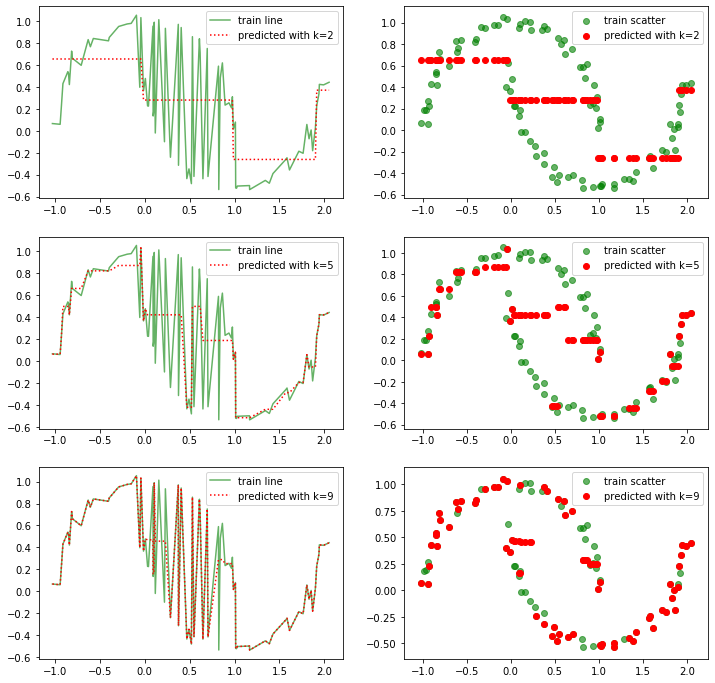

In [351]:
xtr1 = xtr1.reshape(-1,1)
xte1 = xte1.reshape(-1,1)
# print(xtr1.shape, ytr1.shape)
ks = (2,5,9)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

for i, k in enumerate(ks):
    DCT = DecisionTreeRegression(1, max_depth=k, ig_func='mae')
    DCT.train(xtr1, ytr1)
    yp1 = DCT.predict(xtr1)

    axes[i][0].plot(xtr1, ytr1, 'g', alpha=.6, label=f"train line")
    axes[i][0].plot(xtr1, yp1, ':r', alpha=1, label=f"predicted with k={k}")

    axes[i][1].scatter(xtr1, ytr1, color='g', alpha=.6, label=f"train scatter")
    axes[i][1].scatter(xte1, yte1, color='g', alpha=.6)
    axes[i][1].scatter(xtr1, yp1, color='r', label=f"predicted with k={k}")
    axes[i][0].legend()
    axes[i][1].legend()
    
fig.savefig("norm_DTR_lines.png", dpi=150)